# Proyecto OCR

#
**Librerias**

In [2]:
import fitz
from PIL import Image
import requests
from flask import Flask, request
from io import BytesIO
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
import pyodbc
print(pyodbc.drivers())
from transformers import pipeline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

['SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'SQL Server Native Client 11.0', 'SQL Server Native Client RDA 11.0', 'ODBC Driver 13 for SQL Server', 'ODBC Driver 18 for SQL Server', 'ODBC Driver 17 for SQL Server']


#
**Extraer textos de PDFs**

In [4]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

pdf_text = extract_text_from_pdf(r"C:\Users\DELL\Desktop\Samsung\Doc-Finder\.vs\Doc-Finder\Base de datos\Ley núm. 1-25.pdf")
print(pdf_text)

n
EL CONGRESO NACIONAL
EN NOMBRE DE LA REPÚBLICA
Ley num. 1-25   
Ley que modifica la Ley núm.138-11, del 21 de junio de 2011,
Ley Orgánica
del Consejo Nacional
de
la Magistratura
Que
el
Consejo
Nacional
de
la
Magistratura
es
el
Considerando
primero:
órgano
constitucional,
integrado
de
forma
plural,
con
la
función
de
designar
a
los
jueces
de
la
Suprema
Corte
de
Justicia,
los
del
Tribunal
Constitucional,
los
del
Tribunal
Superior Electoral
y
sus
suplentes
y al
procuradores
Procurador
General
de
la
República
y
la
mitad
de
los
adjuntos,
a
propuesta
del
Presidente
de
la
República;
asi
como
evaluar
el
desempeño
de
los
jueces
de
la Suprema Corte
de
Justicia;
Considerando
segundo:
Que
el
2 7
de
octubre
de
2 02 4
fue
proclamada
una
nueva Constitución
de
la República,
la
que
en
la parte dispositiva
de
su
El
Presidente
de
la
República,
dentro
de
los
articulo
171
dispone:
\\
primeros
cien
dias
de
su
mandato
constitucional,
propondrá
al
Consejo
Nacional
de
la
Magistratura
una
persona
para
ser
desi

#
**Extraer datos de imagenes**

**Imagen de ejemplo**

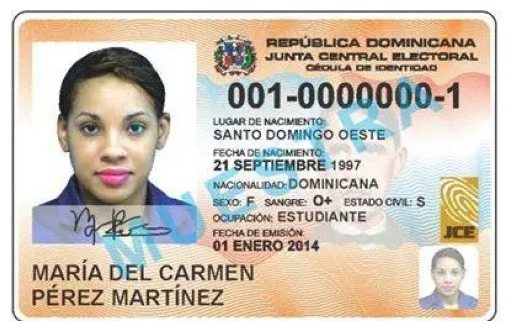

In [5]:
image_2_show = mpimg.imread(r"C:\Users\DELL\Desktop\Samsung\Doc-Finder\.vs\Doc-Finder\Base de datos\cedula 1.jpeg")
plt.imshow(image_2_show)
plt.axis('off')
plt.show()

In [ ]:
def extract_text_from_image(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image)
    return text

image_text = extract_text_from_image(r"C:\Users\oswal\text_image_orc.jpg")
print(f"La imagen dice: {image_text}")

#
**Conexión a SQL Server**

In [ ]:
driver_name = "ODBC Driver 17 for SQL Server"
server_ip = "192.168.1.3"
port = 1433
database_name = "documents_database"
database_user = "bricksbreaker"
database_password = "puchi15063022"

connection_str = (
    f"DRIVER={{{driver_name}}};"
    f"SERVER={server_ip},{port};"
    f"DATABASE={database_name};"
    f"UID={database_user};"
    f"PWD={database_password};"
)

connection = pyodbc.connect(connection_str)
print("Conectado correctamente") 

In [ ]:
cursor = connection.cursor()

cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';")
tables = cursor.fetchall()

print(f"Tablas en la base de datos {database_name}:")
for table in tables:
    print(table[0])

**Insertar documento a la base de datos**

In [ ]:
def insert_document(CategoryID, FilePath, Uploaded, ExtractedText):
    cursor = connection.cursor()
    cursor.execute("""
        INSERT INTO documents (CategoryID, FilePath, Uploaded, ExtractedText)
        VALUES (?, ?, ?, ?)
    """, (CategoryID, FilePath, Uploaded, ExtractedText))
    connection.commit()
    print(f"Se ha insertado el documento {FilePath} en la base de datos")

insert_document(1, r"C:\Users\oswal\Desktop\EpicGames\IP Partner Licensing Agreement.pdf", '2025-03-22', pdf_text)

In [6]:
def process_document(FilePath, Uploaded):
    extracted_text = exctact_text_from_pdf(FilePath)
    category = classify_document(extracted_text)
    category_id = get_category_id(category)
    insert_document(category_id, FilePath, Uploaded, extracted_text)
    print(f"Se ha procesado el documento {FilePath} y ha sido guardado en la base de datos.")

In [7]:
def get_category_id_by_name(category_name):
    cursor = connection.cursor()
    cursor.execute("SELECT CategoryID FROM categories WHERE CategoryName = ?", (category_name,))
    result = cursor.fetchone()[0]
    return result[0] if result else None

#
**Uso de GPU/CPU**

In [8]:
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

Using device: CPU


#
**Modelo de Zero Shot Image Classification - Facebook**

**Imagen de acuerdo de pago**

In [ ]:
image_2_show_2 = mpimg.imread(r"C:\Users\oswal\Pictures\Screenshots\Imagen_de_acuerdo_legal.png")
plt.imshow(image_2_show_2)
plt.axis('off')
plt.show()

#
**Ejemplos de funcionalidad**

In [9]:
def clasificar_imagen_zero_shot(ruta_imagen, etiquetas=None):
    if etiquetas is None:
        etiquetas = [
            "Contrato",
            "Factura",
            "Recibo",
            "Identificación personal",
            "Informe",
            "Currículum / Hoja de vida",
            "Certificado",
            "Licencia o permiso",
            "Correspondencia (cartas, emails)",
            "Documentación legal",
            "Documentación técnica",
            "Manual o guía",
            "Proyecto",
            "Planificación / Agenda",
            "Otros"
        ]

    classifier = pipeline("zero-shot-image-classification", model="facebook/metaclip-b16-fullcc2.5b")
    imagen = Image.open(ruta_imagen)
    resultado = classifier(imagen, candidate_labels=etiquetas)
    return resultado

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\Imagen_de_acuerdo_legal.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\acta.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\asamblea.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\certificado.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\onapi.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

**Función de clasificar documentos**

In [10]:
def classify_document(text, categories):
    """
    Clasifica el texto de un documento en una categoría usando clasificación zero-shot.
    
    Args:
        text (str): Texto del documento a clasificar.
        categories (list): Lista de categorías posibles.
    
    Returns:
        str: Categoría predicha para el documento.
    """

    result = classifier(text, candidate_labels=categories)
    return result["labels"][0]


In [11]:
def get_categories_from_db():
    """"
    Obtiene las categorías almacenadas en la base de datos.

    Returns:
        list: Lista de categorías almacenadas en la base de datos.
    """

    cursor = connection.cursor()
    cursor.execute("SELECT CategoryName FROM dbo.Categories")
    categories = [row[0] for row in cursor.fetchall()]
    return categories

In [12]:
def classify_and_update_document(DocumentID, ExtractedText):

    categories = get_categories_from_db()
    predicted_category = classify_document(ExtractedText, categories)

    cursor = connection.cursor()
    cursor.execute("""
        UPDATE dbo.Documents
        SET CategoryID = (SELECT CategoryID FROM dbo.Categories WHERE CategoryName = ?)
        WHERE DocumentID = ?
    """, (predicted_category, DocumentID))
    connection.commit()
    print(f"Se ha clasificado el documento {DocumentID} como {predicted_category}")

In [ ]:
DocumentID = 1
ExtractedText = extract_text_from_pdf(r"C:\Users\oswal\Epic Games - Island Creator Program.pdf")
classify_and_update_document(DocumentID, ExtractedText)

In [14]:
import os

def obtener_archivos_carpeta(carpeta):
    archivos = []
    for nombre in os.listdir(carpeta):
        ruta_completa = os.path.join(carpeta, nombre)
        if os.path.isfile(ruta_completa):  # solo archivos, no subcarpetas
            archivos.append(ruta_completa)
    return archivos


In [16]:
from openai import OpenAI
import os

# Cliente DeepSeek
client = OpenAI(
    api_key="sk-1c61d586aa734348952523cf4516d3ac",
    base_url="https://api.deepseek.com"
)

def obtener_archivos_carpeta(carpeta):
    archivos = []
    for nombre in os.listdir(carpeta):
        ruta_completa = os.path.join(carpeta, nombre)
        if os.path.isfile(ruta_completa):
            archivos.append(ruta_completa)
    return archivos

def buscar_documentos_inteligente(consulta, carpeta_docs):
    file_paths = obtener_archivos_carpeta(carpeta_docs)

    if not file_paths:
        return "No se encontraron archivos en la carpeta."

    lista_archivos = "\n".join(f"- {os.path.basename(p)} ({p})" for p in file_paths)

    prompt = f"""
Tienes esta lista de documentos (cualquier tipo de archivo) guardados en la carpeta:

{lista_archivos}

Tarea del usuario: {consulta}

1. Indica qué archivos parecen más relevantes y por qué.
2. Ten en cuenta el tipo de archivo según su extensión (pdf, docx, xlsx, txt, etc.).
3. Devuelve la respuesta en formato de lista clara.
"""

    respuesta = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "Eres un asistente que ayuda a elegir documentos relevantes de una carpeta."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.3,
    )

    return respuesta.choices[0].message.content

def mostrar_resultados(texto):
    print("=== RESULTADOS ===")
    print(texto)

# Ejemplo de uso
carpeta_docs = "C:\\Users\\DELL\\Desktop\\Samsung\\Doc-Finder\\.vs\\Doc-Finder\\Base de datos"  # cambia esto a la carpeta que estás usando
resultados = buscar_documentos_inteligente("Busca documentos relevantes del 2025", carpeta_docs)
mostrar_resultados(resultados)


ModuleNotFoundError: No module named 'openai'